In [2]:
# importing necessary modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils
# from tensorflow.keras.utils import to_categorical
# from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Get Features data from compressed file

In [2]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('data_x.npz')
# extract the first array
X = dict_data['arr_0']
# print the array
print(X)


[[ 7.61570786e-02  6.56093121e-01  6.97486043e-01 ... -5.49116870e-02
   8.43622550e-03  8.68360564e-03]
 [ 3.19148516e-01  7.88175575e-01  7.97310264e-01 ... -4.54879980e-02
   6.22307115e-03  3.68944098e-03]
 [ 7.96194366e-02  7.41017640e-01  6.35196090e-01 ... -6.75728546e-02
   1.07973404e-02 -1.56228028e-02]
 ...
 [ 4.21099154e-02  6.06974602e-01  6.26703024e-01 ... -8.72499610e-03
  -2.71237992e-04  8.32928067e-03]
 [ 4.41170794e-02  6.30543611e-01  6.68172135e-01 ... -1.16808890e-02
  -2.20377119e-03  8.63203886e-03]
 [ 4.50589025e-02  5.49822748e-01  5.96909761e-01 ...  1.06826018e-02
   6.74372531e-03 -6.59982994e-03]]


In [3]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('data_y.npz')
# extract the first array
Y = dict_data['arr_0']
# print the array
print(Y)


['angry' 'angry' 'angry' ... 'surprise' 'surprise' 'surprise']


In [4]:
X.shape, Y.shape


((36621, 187), (36621,))

In [5]:
Features = pd.DataFrame(X)
Features['labels'] = Y

Features.shapeFeatures = pd.DataFrame(X)
Features['labels'] = Y

Features.shape


(36621, 188)

In [6]:
Features.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,labels
0,0.076157,0.656093,0.697486,0.684813,0.680425,0.670918,0.575612,0.571766,0.629165,0.661047,...,19.071780,18.205848,64.143048,0.011220,0.014544,-0.039381,-0.054912,0.008436,0.008684,angry
1,0.319149,0.788176,0.797310,0.812976,0.829499,0.847087,0.707635,0.653075,0.712158,0.703063,...,15.328932,14.800526,13.616032,0.007847,0.007250,-0.010280,-0.045488,0.006223,0.003689,angry
2,0.079619,0.741018,0.635196,0.690803,0.682903,0.649258,0.640377,0.538545,0.533444,0.604091,...,18.945783,18.753808,65.110960,-0.040476,-0.005076,0.060663,-0.067573,0.010797,-0.015623,angry
3,0.068002,0.714656,0.741048,0.658524,0.676285,0.686411,0.614934,0.584842,0.618500,0.691588,...,18.087724,17.060770,63.748496,-0.008231,-0.019454,-0.039172,-0.033343,0.011401,0.004871,disgust
4,0.158222,0.796261,0.801238,0.758541,0.789688,0.792804,0.685369,0.635259,0.666385,0.723402,...,15.605381,15.044415,14.347040,-0.000711,-0.010401,-0.049108,-0.020721,0.007966,0.010416,disgust


In [7]:
track_features = [
    ['ZCR', 1],
    ['Chroma_stft', 12],
    ['poly_features', 10],
    ['MFCC', 20],
    ['RMS', 1],
    ['MelSpectogram', 128],
    ['spectral centroid', 1],
    ['spectral rolloff', 1],
    ['spectral contrast', 7],
    ['tonnetz', 6]
]

column_tracker, temp = [0], 0
for data in track_features:
    temp += data[1]
    column_tracker.append(temp)

print("Total number of columns:", column_tracker[-1])

tracker = pd.DataFrame(track_features, columns=[
                       'Features', 'Number of Columns Occupied'])
tracker['Starts From'] = column_tracker[:-1]

tracker


Total number of columns: 187


,Features,Number of Columns Occupied,Starts From
0,ZCR,1,0
1,Chroma_stft,12,1
2,poly_features,10,13
3,MFCC,20,23
4,RMS,1,43
5,MelSpectogram,128,44
6,spectral centroid,1,172
7,spectral rolloff,1,173
8,spectral contrast,7,174
9,tonnetz,6,181


`Note: The cell below must be run only once on the original Feature Instance`

In [8]:
# Select the features that are to be removed by its index in the dataframe above
# To be given as comma separated values
to_remove = "0, 1, 5, 4"

to_remove = sorted(
    list(map(lambda x: int(x.strip()), to_remove.split(','))), reverse=True)

for num in to_remove:
    Features = Features.drop(
        Features.iloc[:, column_tracker[num]:column_tracker[num + 1]], axis=1)


Features.shape

(36621, 46)

In [9]:
Features.head()

,13,14,15,16,17,18,19,20,21,22,...,178,179,180,181,182,183,184,185,186,labels
0,1.054322e-32,-5.486079e-28,1.202762e-23,-1.443139e-19,1.029687e-15,-4.439745e-12,1.120534e-08,-0.000015,0.008053,0.746747,...,19.071780,18.205848,64.143048,0.011220,0.014544,-0.039381,-0.054912,0.008436,0.008684,angry
1,9.830436e-33,-5.120680e-28,1.124357e-23,-1.351848e-19,9.671927e-16,-4.185356e-12,1.061452e-08,-0.000014,0.007779,0.873353,...,15.328932,14.800526,13.616032,0.007847,0.007250,-0.010280,-0.045488,0.006223,0.003689,angry
2,6.314494e-33,-3.296065e-28,7.249647e-24,-8.726390e-20,6.244969e-16,-2.699533e-12,6.826591e-09,-0.000009,0.004963,0.426066,...,18.945783,18.753808,65.110960,-0.040476,-0.005076,0.060663,-0.067573,0.010797,-0.015623,angry
3,4.593590e-33,-2.345932e-28,5.024216e-24,-5.850287e-20,4.012203e-16,-1.638149e-12,3.815207e-09,-0.000004,0.001645,0.779916,...,18.087724,17.060770,63.748496,-0.008231,-0.019454,-0.039172,-0.033343,0.011401,0.004871,disgust
4,4.434255e-33,-2.265915e-28,4.856922e-24,-5.661748e-20,3.888246e-16,-1.590076e-12,3.709430e-09,-0.000004,0.001600,0.790477,...,15.605381,15.044415,14.347040,-0.000711,-0.010401,-0.049108,-0.020721,0.007966,0.010416,disgust


## Model Training and Testing

In [10]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values


In [11]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()


In [12]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((27465, 45), (27465, 8), (9156, 45), (9156, 8))

In [13]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((27465, 45), (27465, 8), (9156, 45), (9156, 8))

In [14]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((27465, 45, 1), (27465, 8), (9156, 45, 1), (9156, 8))

In [15]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same',
          activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1,
          padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1,
          padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1,
          padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 45, 256)           1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 6, 128)           0

In [16]:
epochs = 30

In [17]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs,
                    validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/30
430/430 [==============================] - 32s 72ms/step - loss: 1.7949 - accuracy: 0.2721 - val_loss: 1.5884 - val_accuracy: 0.3551 - lr: 0.0010
Epoch 2/30
430/430 [==============================] - 26s 60ms/step - loss: 1.5714 - accuracy: 0.3621 - val_loss: 1.4637 - val_accuracy: 0.4008 - lr: 0.0010
Epoch 3/30
430/430 [==============================] - 30s 71ms/step - loss: 1.4779 - accuracy: 0.4006 - val_loss: 1.4159 - val_accuracy: 0.4270 - lr: 0.0010
Epoch 4/30
430/430 [==============================] - 29s 68ms/step - loss: 1.4183 - accuracy: 0.4260 - val_loss: 1.3488 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 5/30
430/430 [==============================] - 29s 67ms/step - loss: 1.3748 - accuracy: 0.4462 - val_loss: 1.3608 - val_accuracy: 0.4542 - lr: 0.0010
Epoch 6/30
430/430 [==============================] - 31s 71ms/step - loss: 1.3409 - accuracy: 0.4573 - val_loss: 1.3123 - val_accuracy: 0.4712 - lr: 0.0010
Epoch 7/30
430/430 [==============================] - 29s 

In [18]:
model_filename = "lstm.pkl"
joblib.dump(history, model_filename)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv1d
......vars
.........0
.........1
...layers\conv1d_1
......vars
.........0
.........1
...layers\conv1d_2
......vars
.........0
.........1
...layers\conv1d_3
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\flatten
......vars
...layers\max_pooling1d
......vars
...layers\max_pooling1d_1
......vars
...layers\max_pooling1d_2
......vars
...layers\max_pooling1d_3
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........3
.........4
.........5
.........6

['lstm.pkl']

In [4]:
model_filename = "lstm.pkl"
history = joblib.load(model_filename)
model = history.model

print("Accuracy of our model on test data : ",
      model.evaluate(x_test, y_test)[1]*100, "%")

epochs = [i for i in range(epochs)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
plt.grid(axis='y')

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.grid(axis='y')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'lstm.pkl'

In [20]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


287/287 [==============================] - 2s 8ms/step


In [21]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)


,Predicted Labels,Actual Labels
0,neutral,neutral
1,surprise,surprise
2,disgust,disgust
3,angry,angry
4,happy,disgust
5,neutral,disgust
6,angry,angry
7,disgust,disgust
8,disgust,disgust
9,disgust,sad


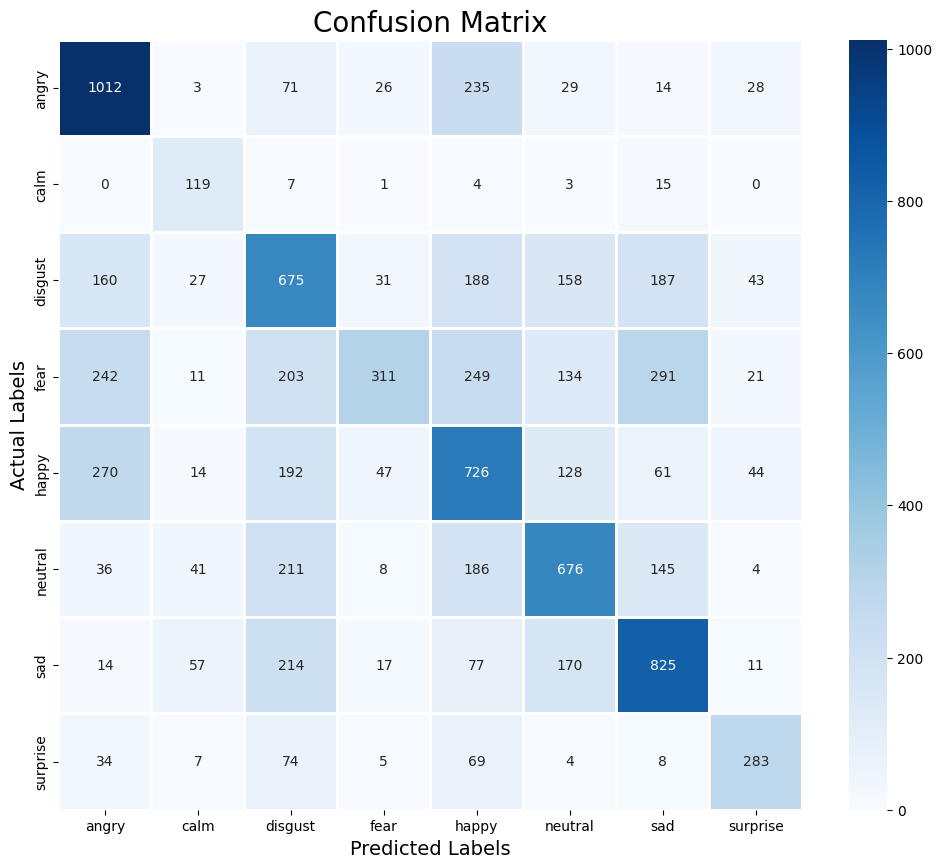

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
                  i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues',
            linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


In [23]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.57      0.71      0.64      1418
        calm       0.43      0.80      0.56       149
     disgust       0.41      0.46      0.43      1469
        fear       0.70      0.21      0.33      1462
       happy       0.42      0.49      0.45      1482
     neutral       0.52      0.52      0.52      1307
         sad       0.53      0.60      0.56      1385
    surprise       0.65      0.58      0.62       484

    accuracy                           0.51      9156
   macro avg       0.53      0.55      0.51      9156
weighted avg       0.53      0.51      0.49      9156

